# setup

In [1]:
!nvidia-smi

Mon Nov 25 21:15:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:85:00.0 Off |                    0 |
| N/A   40C    P0             45W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install langchain langchain-huggingface bitsandbytes datasets matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import getpass
import os
import pandas as pd

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

In [4]:
api_env_key = "HUGGINGFACEHUB_API_TOKEN"
if os.environ.get(api_env_key) is None:
    os.environ[api_env_key] = getpass.getpass(
        "Enter your Hugging Face API key: "
    )

Enter your Hugging Face API key:  ········


In [5]:
# Load shared utility methods
%run SharedUtils.ipynb

In [6]:
# Load LLAMA
%run LoadLLAMA.ipynb

2024-11-25 21:15:57.775857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 21:15:57.800223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 21:15:57.807873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 21:15:57.827070: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 21:16:02.307272: W tensorflow/compiler/tf2

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

128009
<class 'int'>


In [8]:
df = pd.read_csv('../hate-speech-dataset/annotations_metadata.csv')
df.head()

relation_df = df[df['label'] == 'relation']
skip_df = df[df['label'] == 'idk/skip']

# get rid of relation and skipped labels
df = df.loc[df['label'] != 'relation']
df = df.loc[df['label'] != 'idk/skip']

# add sentence column directly to df
def add_sentence_column(row):
    file_path = f'../hate-speech-dataset/all_files/{row["file_id"]}.txt'
    try:
        with open(file_path, 'r') as file:
            return file.read().strip()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
df['sentence'] = df.apply(add_sentence_column, axis=1)

In [9]:
# display summary and value counts for labels
print(f"relation removed: {len(relation_df)}")
print(f"idk/skip removed: {len(skip_df)}")
print(f"Remaining rows: {len(df)}")
print(df['label'].value_counts())
display(df)

relation removed: 168
idk/skip removed: 73
Remaining rows: 10703
label
noHate    9507
hate      1196
Name: count, dtype: int64


,file_id,user_id,subforum_id,num_contexts,label,sentence
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...
...,...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate,"Billy - `` That guy would n't leave me alone ,..."
10940,33677019_1,735154,1388,0,noHate,Wish we at least had a Marine Le Pen to vote f...
10941,33677019_2,735154,1388,0,noHate,Its like the choices are white genocide candid...
10942,33677053_1,572266,1388,0,hate,Why White people used to say that sex was a si...


In [10]:
train_df, val_test_df = train_test_split(df, test_size=0.2, stratify=df['label'])
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['label'])
print(len(train_df), len(val_df), len(test_df))

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.head()

8562 1070 1071


,file_id,user_id,subforum_id,num_contexts,label,sentence
0,13291349_2,573432,1345,5,noHate,Look at those pictures .
1,30756236_1,572126,1362,0,noHate,I already have most of the above .
2,13553238_1,579603,1347,0,noHate,You mean like how there was no electricty or o...
3,13449582_3,572427,1347,0,noHate,Just the yo crap .
4,14064879_1,577015,1383,0,noHate,Plans for largest mosque in Ireland given go a...


In [11]:
train_set = Dataset.from_pandas(train_df)
test_set = Dataset.from_pandas(test_df)

print(train_set[:5])
print(test_set[:5])

{'file_id': ['13291349_2', '30756236_1', '13553238_1', '13449582_3', '14064879_1'], 'user_id': [573432, 572126, 579603, 572427, 577015], 'subforum_id': [1345, 1362, 1347, 1347, 1383], 'num_contexts': [5, 0, 0, 0, 0], 'label': ['noHate', 'noHate', 'noHate', 'noHate', 'noHate'], 'sentence': ['Look at those pictures .', 'I already have most of the above .', 'You mean like how there was no electricty or other public services except the post office and some roads during the Old Republic ?', 'Just the yo crap .', 'Plans for largest mosque in Ireland given go ahead Read more : Plans for largest mosque in Ireland given go ahead | Irish News | IrishCentral Follow us : @IrishCentral on Twitter | IrishCentral on Facebook']}
{'file_id': ['13462686_14', '13482120_1', '31711132_12', '31746244_1', '13849033_1'], 'user_id': [575159, 585022, 586614, 599957, 579630], 'subforum_id': [1347, 1346, 1363, 1363, 1391], 'num_contexts': [0, 0, 0, 0, 0], 'label': ['noHate', 'noHate', 'noHate', 'noHate', 'noHate'

In [12]:
label_map = {
    "hate": "hate",
    "noHate": "nohate"
}
label_values = list(label_map.values())

train_set = train_set.map(map_labels)
test_set = test_set.map(map_labels)

X_test = test_set["sentence"]
y_test = test_set["label_human"]

print(train_set[:5])
print(test_set[:5])

Map:   0%|          | 0/8562 [00:00<?, ? examples/s]

Map:   0%|          | 0/1071 [00:00<?, ? examples/s]

{'file_id': ['13291349_2', '30756236_1', '13553238_1', '13449582_3', '14064879_1'], 'user_id': [573432, 572126, 579603, 572427, 577015], 'subforum_id': [1345, 1362, 1347, 1347, 1383], 'num_contexts': [5, 0, 0, 0, 0], 'label': ['noHate', 'noHate', 'noHate', 'noHate', 'noHate'], 'sentence': ['Look at those pictures .', 'I already have most of the above .', 'You mean like how there was no electricty or other public services except the post office and some roads during the Old Republic ?', 'Just the yo crap .', 'Plans for largest mosque in Ireland given go ahead Read more : Plans for largest mosque in Ireland given go ahead | Irish News | IrishCentral Follow us : @IrishCentral on Twitter | IrishCentral on Facebook'], 'label_human': ['nohate', 'nohate', 'nohate', 'nohate', 'nohate']}
{'file_id': ['13462686_14', '13482120_1', '31711132_12', '31746244_1', '13849033_1'], 'user_id': [575159, 585022, 586614, 599957, 579630], 'subforum_id': [1347, 1346, 1363, 1363, 1391], 'num_contexts': [0, 0, 0

In [13]:
def get_reasoning(label):
    reasoning_map = {
        "hate": "This sentence contains hateful or derogatory language targeted at individuals or groups. The tone is hostile, offensive, or intentionally harmful.",
        "noHate": "This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting individuals or groups in an offensive or harmful way."
    }
    return reasoning_map.get(label)

In [14]:
few_shot_examples, examples_text, examples_text_cot = prepare_examples(train_set, key="sentence", n_per_label=1)

print(few_shot_examples)
print("---")
print(examples_text)
print("---")
print(examples_text_cot)

[{'file_id': '30623542_2', 'user_id': 607125, 'subforum_id': 1362, 'num_contexts': 0, 'label': 'noHate', 'sentence': "And it 's true !", 'label_human': 'nohate'}, {'file_id': '14674224_2', 'user_id': 577613, 'subforum_id': 1371, 'num_contexts': 0, 'label': 'hate', 'sentence': 'Any kind of civilization Negroes have today is a gift from the White race .', 'label_human': 'hate'}]
---
Sentence: And it 's true !
Sentiment: nohate
Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Sentiment: hate
---
Sentence: And it 's true !
Reasoning: This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting individuals or groups in an offensive or harmful way.
Sentiment: nohate
Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Reasoning: This sentence contains hateful or derogatory language targeted at individuals or groups. The tone is hostile, offensive, or intentionally harmful.

# Zero-Shot Prompting Preview

In [15]:
ai_msg = zero_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .")
print(ai_msg) # nohate

ai_msg = zero_shot("Events around the world will educate her fast enough !")
print(ai_msg) # hate

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: hate, nohate.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sentiment: nohate
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: hate, nohate.

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

Events around the world will educate he

# Few-Shot Prompting Preview

In [16]:
ai_msg = few_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .", examples_text)
print(ai_msg)

ai_msg = few_shot("Events around the world will educate her fast enough !", examples_text)
print(ai_msg)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: hate, nohate.

Here are some examples:
Sentence: And it 's true !
Sentiment: nohate
Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Sentiment: hate

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Sentiment: nohate
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: hate, nohate.

Here are some examp

# Few-Shot with Chain-of-Thought Preview

In [17]:
ai_msg = few_shot("Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet everyone .", examples_text_cot)
print(ai_msg)

ai_msg = few_shot("Events around the world will educate her fast enough !", examples_text_cot)
print(ai_msg)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Your goal is to read a sentence and classify its sentiment into one of the following categories: hate, nohate.

Here are some examples:
Sentence: And it 's true !
Reasoning: This sentence does not contain hateful language. It may express neutral or positive sentiment without targeting individuals or groups in an offensive or harmful way.
Sentiment: nohate
Sentence: Any kind of civilization Negroes have today is a gift from the White race .
Reasoning: This sentence contains hateful or derogatory language targeted at individuals or groups. The tone is hostile, offensive, or intentionally harmful.
Sentiment: hate

Now classify the following sentence. The output MUST follow this format:
Sentiment: [Classification]<|eot_id|><|start_header_id|>user<|end_header_id|>

Thanks to all the people that have come out to meet up recently it has been a real pleasure to meet every

# Zero-Shot Evaluation

In [18]:
# sampleset = test_set.select(range(100))
# s_X_test = sampleset["sentence"]
# s_y_test = sampleset["label_human"]

In [19]:
zero_shot_results = evaluate_model(X_test, y_test, zero_shot, None)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


---
Sentence: Yeah London has gone to hell , when all the remaining whites are gone it will become a zombie town of crumbling buildings , dealers and junkies .
True: hate
Prediction: hate
Processed 100/1071 examples, Time: 48.200
---

---
Sentence: Thank you and this is video I 've made for all of us after I made those for each ethnics : Sons of Europe - Legacy - YouTube Only Unity
True: nohate
Prediction: nohate
Processed 200/1071 examples, Time: 98.878
---

---
Sentence: Want to see our fate if we do n't win ?
True: nohate
Prediction: hate
Processed 300/1071 examples, Time: 158.383
---

---
Sentence: The thought of Africans in space is laughable .
True: hate
Prediction: hate
Processed 400/1071 examples, Time: 207.508
---

---
Sentence: Ahhh Mandela ....... All those years in prison were not wasted .
True: nohate
Prediction: nohate
Processed 500/1071 examples, Time: 254.033
---

---
Sentence: The liberals are going to get their panties in a bunch , with people like you saying we must 

Filtered 319 invalid predictions.
Accuracy: 70.7447
              precision    recall  f1-score   support

        hate       0.24      0.87      0.38        77
      nohate       0.98      0.69      0.81       675

    accuracy                           0.71       752
   macro avg       0.61      0.78      0.59       752
weighted avg       0.90      0.71      0.76       752



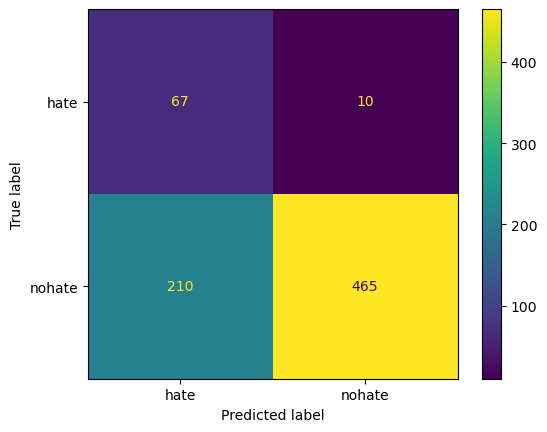

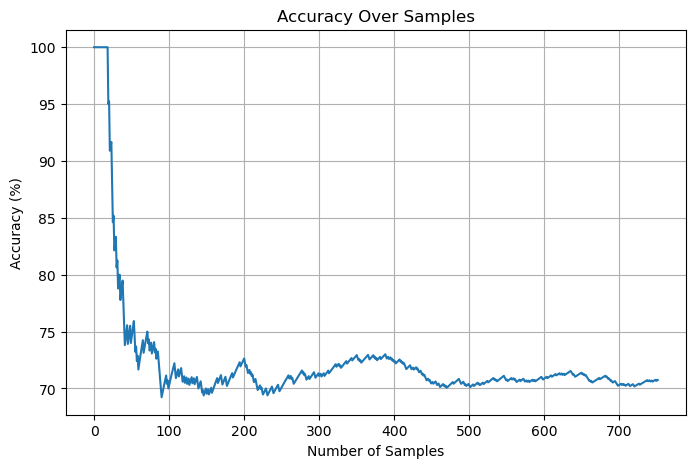

In [20]:
create_reports(y_test, zero_shot_results)

# Few-Shot Evaluation

In [21]:
few_shot_results = evaluate_model(X_test, y_test, few_shot, examples_text)

---
Sentence: Yeah London has gone to hell , when all the remaining whites are gone it will become a zombie town of crumbling buildings , dealers and junkies .
True: hate
Prediction: hate
Processed 100/1071 examples, Time: 60.536
---

---
Sentence: Thank you and this is video I 've made for all of us after I made those for each ethnics : Sons of Europe - Legacy - YouTube Only Unity
True: nohate
Prediction: nohate
Processed 200/1071 examples, Time: 132.033
---

---
Sentence: Want to see our fate if we do n't win ?
True: nohate
Prediction: nohate
Processed 300/1071 examples, Time: 198.827
---

---
Sentence: The thought of Africans in space is laughable .
True: hate
Prediction: invalid
Processed 400/1071 examples, Time: 256.285
---

---
Sentence: Ahhh Mandela ....... All those years in prison were not wasted .
True: nohate
Prediction: nohate
Processed 500/1071 examples, Time: 324.664
---

---
Sentence: The liberals are going to get their panties in a bunch , with people like you saying we

Filtered 305 invalid predictions.
Accuracy: 86.2924
              precision    recall  f1-score   support

        hate       0.25      0.74      0.38        43
      nohate       0.98      0.87      0.92       723

    accuracy                           0.86       766
   macro avg       0.62      0.81      0.65       766
weighted avg       0.94      0.86      0.89       766



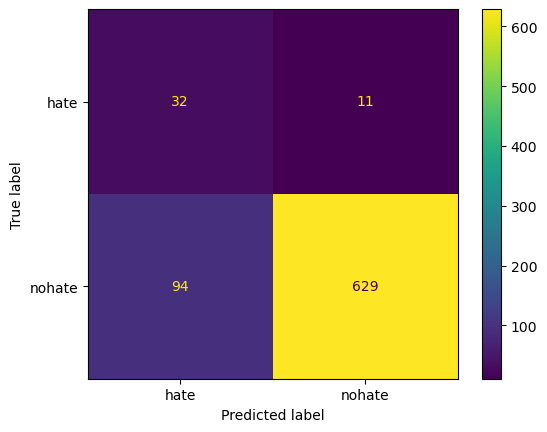

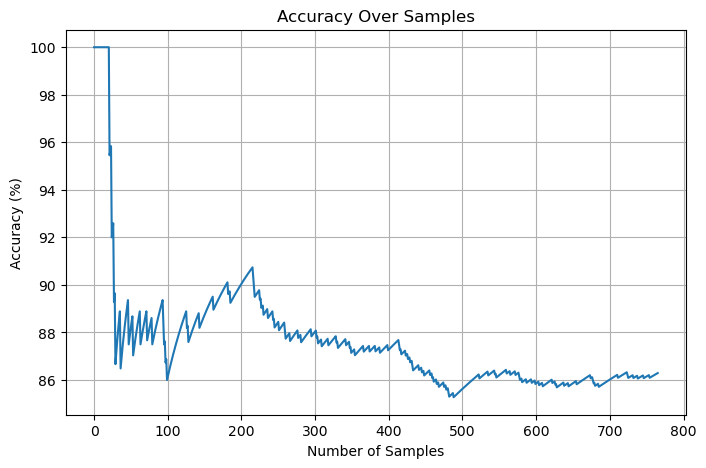

In [22]:
create_reports(y_test, few_shot_results)

# Few-Shot Chain-of-Thought Evaluation

In [23]:
few_shot_cot_results = evaluate_model(X_test, y_test, few_shot, examples_text_cot)

---
Sentence: Yeah London has gone to hell , when all the remaining whites are gone it will become a zombie town of crumbling buildings , dealers and junkies .
True: hate
Prediction: hate
Processed 100/1071 examples, Time: 51.890
---

---
Sentence: Thank you and this is video I 've made for all of us after I made those for each ethnics : Sons of Europe - Legacy - YouTube Only Unity
True: nohate
Prediction: nohate
Processed 200/1071 examples, Time: 108.489
---

---
Sentence: Want to see our fate if we do n't win ?
True: nohate
Prediction: nohate
Processed 300/1071 examples, Time: 173.928
---

---
Sentence: The thought of Africans in space is laughable .
True: hate
Prediction: hate
Processed 400/1071 examples, Time: 231.308
---

---
Sentence: Ahhh Mandela ....... All those years in prison were not wasted .
True: nohate
Prediction: nohate
Processed 500/1071 examples, Time: 289.054
---

---
Sentence: The liberals are going to get their panties in a bunch , with people like you saying we mu

Filtered 80 invalid predictions.
Accuracy: 84.0565
              precision    recall  f1-score   support

        hate       0.35      0.77      0.48        94
      nohate       0.97      0.85      0.91       897

    accuracy                           0.84       991
   macro avg       0.66      0.81      0.69       991
weighted avg       0.91      0.84      0.87       991



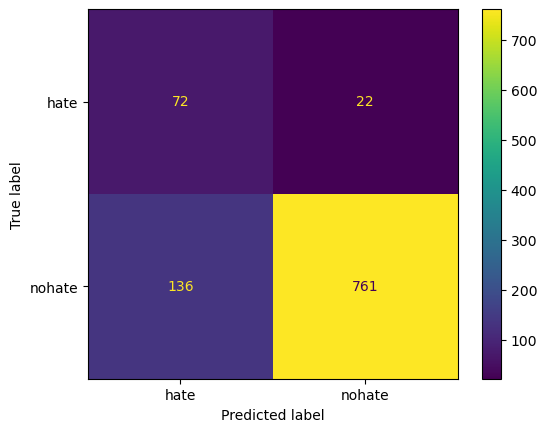

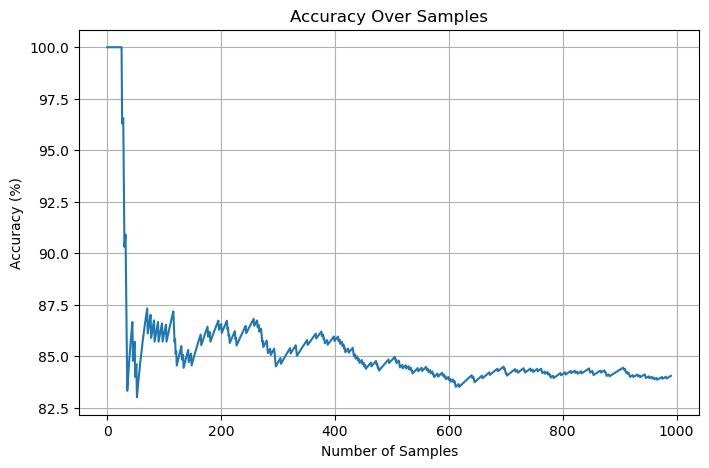

In [24]:
create_reports(y_test, few_shot_cot_results)